In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='7'
from diffusers import DiffusionPipeline, StableDiffusionImg2ImgPipeline, AutoencoderKL,StableDiffusionPipeline

from transformers import AutoTokenizer, DistilBertForSequenceClassification
from diffusers import EulerDiscreteScheduler
import torch

2023-07-08 15:33:29.774648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 15:33:30.516366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
import torch
from PIL import Image
import numpy as np

In [3]:
from convert_prompt import * 
from embedding import * 
from text_encoder_hijack import * 
from textual_inversion import * 

In [4]:
generator = DiffusionPipeline.from_pretrained("../model/BlueBoys_2D_v3",torch_dtype=torch.float16,safety_checker=None)

vae = AutoencoderKL.from_pretrained("../model/vae_840000_ema_pruned",torch_dtype=torch.float16,subfolder="vae").to("cuda")
generator.vae = vae  # 替换vaetok

generator.scheduler = EulerDiscreteScheduler.from_config(generator.scheduler.config)

generator.to("cuda")  # 使用gpu

/data1/env/miniconda3/envs/wy_py310/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.18.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
CLIP_Tokenizer = generator.tokenizer
CLIP_TextModel = generator.text_encoder

In [6]:
# load TextualInversion
TextualInversion = TextualInversionPlug('../model/textual_inversion',tokenizer = CLIP_Tokenizer)
TextualInversion.load_textual_inversion()

In [7]:
hijack = TextEncoderHijack()
hijack.hijack_embeding(CLIP_TextModel)

In [8]:
embedding = EmbeddingExtent(tokenizer=CLIP_Tokenizer,text_encoder=CLIP_TextModel,textual_inversion_manager=TextualInversion,hijack=hijack,device="cuda",dtype=torch.float16)


In [9]:
prompt = "(absurdres, highres, ultra detailed), 1 male, handsome, tall muscular guy, very short hair, best ratio four finger and one thumb, best light and shadow, background is back alley, detasiled sunlight, sitting, Little cats are gathered next to him, dappled sunlight, day, depth of field, plants, summer, (dutch angle), closed mouth, summer day"


negative = "(hair between eyes), sketch, duplicate, ugly, huge eyes, text, logo, worst face, (bad and mutated hands:1.3), (worst quality:2.0), (low quality:2.0), (blurry:2.0), horror, geometry, bad_prompt, (bad hands), (missing fingers), multiple limbs, bad anatomy, (interlocked fingers:1.2), Ugly Fingers, (extra digit and hands and fingers and legs and arms:1.4), ((2girl)), (deformed fingers:1.2), (long fingers:1.2), extra legs, upper teeth, parted lips, open mouth"


In [11]:
prompt_pre_embedding = embedding(prompt,CLIP_stop_at_last_layers=1)
negative_prompt_pre_embedding = embedding(negative,CLIP_stop_at_last_layers=1)

In [12]:
prompt_pre_embedding,negative_prompt_pre_embedding = embedding.pad_prompt_tensor_same_length(prompt_emb=prompt_pre_embedding, negative_prompt_emb=negative_prompt_pre_embedding,CLIP_stop_at_last_layers=1)




In [13]:
import random

seed = int(random.randrange(4294967294))
seed=4196966724
print(seed)
Generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(seed, seed + 1)]


image = generator(prompt_embeds=prompt_pre_embedding,
                  width=512,
                  height=768,
                  negative_prompt_embeds=negative_prompt_pre_embedding,
                  num_inference_steps=20,
                  guidance_scale=9,
                  generator=Generator,
                  num_images_per_prompt=1).images

4196966724


  0%|          | 0/20 [00:00<?, ?it/s]

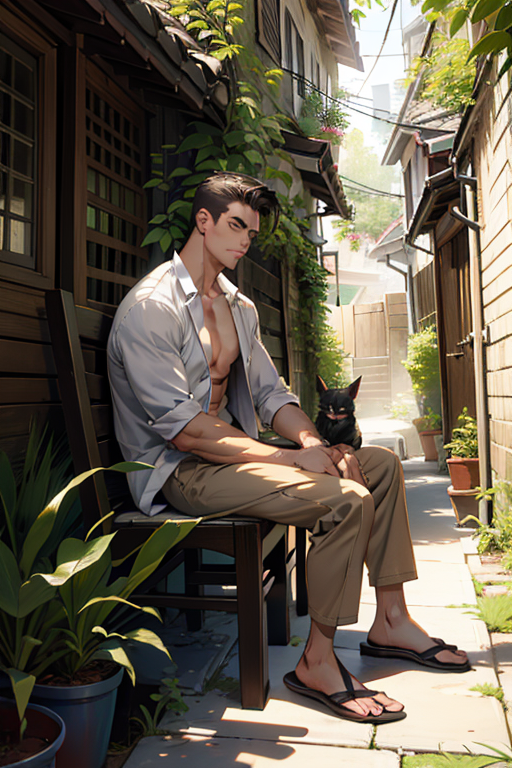

In [14]:
image[0]